In [2]:
import pandas as pd
import numpy as np
import datetime
from data import Data
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, rmspe, aic
from statsmodels.graphics.tsaplots import  plot_acf, plot_pacf, plot_predict

## Relationship with Macro Economic Variable

In [3]:
# hose = pd.read_csv("cleaned data/VNINDEX_2000_2020.csv", index_col = "Date")
# hnx = pd.read_csv("cleaned data/HNXINDEX_2005_2020.csv", index_col = "Date")

# hose.index = pd.to_datetime(hose.index)
# hnx.index = pd.to_datetime(hnx.index)

all_data = Data()
hose, hnx = all_data.hose, all_data.hnx
monthly_macro_df =  all_data.get_macro_df()

In [4]:
# Filter out month end values
def filter_month_end(og_df):
    df = pd.DataFrame()
    df["Date"] = og_df.index
    df["Month"] = [ i.month for i in og_df.index ]
    df["Year"] = [ i.year for i in  og_df.index ]
    month_df = df[["Month","Year","Date"]].groupby(["Year","Month"], as_index = False ).agg({"Date":"max"})

    return month_df.merge(og_df, on = "Date", how = "left", suffixes = [None, "_x"])[["Year", "Month", "Date", "Close"]]

# Merge index data with macroeconomic dat
def make_macro_df(index_month_df, monthly_macro_df, index_name, vars_):
    index_macro = index_month_df.merge(monthly_macro_df, on = ["Year", "Month"],
                                         how = "inner", suffixes = [None, "_x"])
    index_macro.index = pd.to_datetime(index_macro[['Year', 'Month']].assign(DAY=1))
    index_macro = index_macro[vars_].dropna()
    index_macro.set_index(pd.date_range(start = index_macro.index.min(),
                                        periods =len(index_macro),
                                        freq="M"), inplace= True)
    index_macro.rename(columns = {"Close":index_name}, inplace = True)
    return index_macro

# Condect and print result of Augmented Dickey Fuller Test
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

hose_month = filter_month_end(hose)
hnx_month = filter_month_end(hnx)

In [5]:
# Filter out relevant variables
# monthly_macro_df.dropna(subset = ["Economic Activity, Industrial Production, Index"],  inplace = True)

monthly_macro_df = monthly_macro_df[['Time', 'Economic Activity, Industrial Production, Index',
                        'Financial, Interest Rates, Deposit, Percent per annum',
                        'Exchange Rates, Domestic Currency per SDR, Period Average',
                        'Prices, Consumer Price Index, All items, Index']]

macro_vals ={'Economic Activity, Industrial Production, Index':"IIP",
                'Exchange Rates, Domestic Currency per SDR, Period Average':"EXR_SDR",
                'Financial, Interest Rates, Deposit, Percent per annum':"IR_DEPOSIT", 
                'Prices, Consumer Price Index, All items, Index':"CPI" }

monthly_macro_df.rename(columns = macro_vals, inplace=True)
monthly_macro_df["Time"] = pd.to_datetime( monthly_macro_df["Time"])
monthly_macro_df["Month"] = [ i.month for i in monthly_macro_df["Time"]]
monthly_macro_df["Year"] = [ i.year for i in monthly_macro_df["Time"]]

monthly_macro_df.head()

,Time,IIP,IR_DEPOSIT,EXR_SDR,CPI,Month,Year
0,2000-01-01,NaN,3.6,19241.56,48.57,1,2000
1,2000-02-01,NaN,3.6,18905.93,49.33,2,2000
2,2000-03-01,NaN,3.6,18881.99,48.77,3,2000
3,2000-04-01,NaN,3.6,18832.44,48.41,4,2000
4,2000-05-01,NaN,3.6,18452.45,48.13,5,2000


In [6]:
# Merge month end values of stock indeces with macroeconomic variables and scale by taking log
hose_macro = make_macro_df( hose_month,monthly_macro_df, "VN-INDEX", ["Close","EXR_SDR", "IIP","IR_DEPOSIT", "CPI"])
hose_macro = np.log(hose_macro)
hnx_macro = make_macro_df( hnx_month,monthly_macro_df, "HNX-INDEX", ["Close","EXR_SDR", "IIP","IR_DEPOSIT", "CPI"])
hnx_macro = np.log(hnx_macro)

## Testing all variables for Unit Root

Augmented Dickey-Fuller Test: VN-INDEX
ADF Statistic: -0.120620
p-value: 0.947346
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced VN-NDEX
ADF Statistic: -4.877119
p-value: 0.000039
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


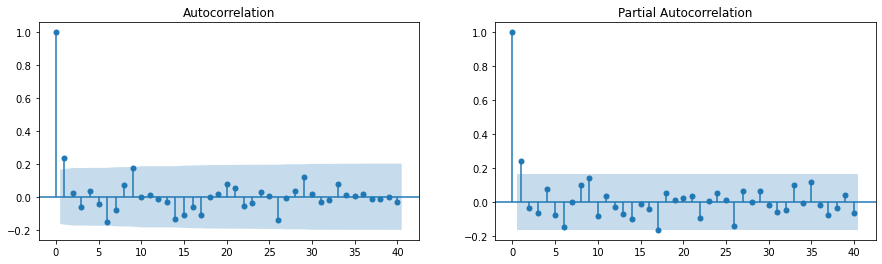

In [7]:
# Stock Indeces
print(f'Augmented Dickey-Fuller Test: VN-INDEX')
augmented_dickey_fuller_statistics(hose_macro["VN-INDEX"])
print(f'Augmented Dickey-Fuller Test: Differenced VN-NDEX')
augmented_dickey_fuller_statistics(hose_macro["VN-INDEX"].diff().dropna())
# Graph hose_macro
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(hose_macro['VN-INDEX'].diff()[1:], lags=40, ax=axes[0])
fig = plot_pacf(hose_macro['VN-INDEX'].diff()[1:], lags=40, ax=axes[1])

Augmented Dickey-Fuller Test: HNX-INDEX
ADF Statistic: -1.746029
p-value: 0.407567
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced HNX-INDEX
ADF Statistic: -7.317641
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


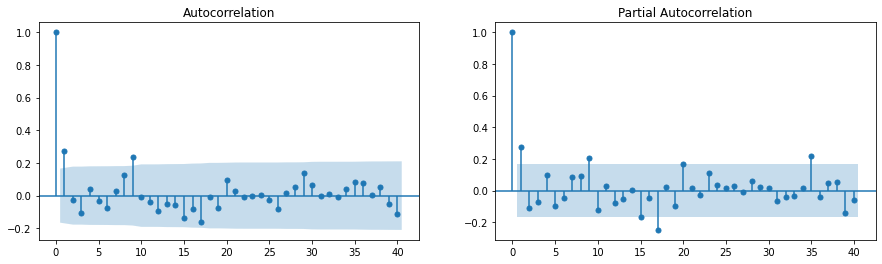

In [8]:
print(f'Augmented Dickey-Fuller Test: HNX-INDEX')
augmented_dickey_fuller_statistics(hnx_macro["HNX-INDEX"])
print(f'Augmented Dickey-Fuller Test: Differenced HNX-INDEX')
augmented_dickey_fuller_statistics(hnx_macro["HNX-INDEX"].diff().dropna())
#Graph hnx-index
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(hnx_macro['HNX-INDEX'].diff()[1:], lags=40, ax=axes[0])
fig = plot_pacf(hnx_macro['HNX-INDEX'].diff()[1:], lags=40, ax=axes[1])

In [10]:
# Macroeconomic Variables
for col in ["IIP", "IR_DEPOSIT","EXR_SDR","CPI"]:
    print(f'Augmented Dickey-Fuller Test: {col}')
    augmented_dickey_fuller_statistics(hose_macro[col])
    print(f'Augmented Dickey-Fuller Test: Differenced {col}')
    augmented_dickey_fuller_statistics(hose_macro[col].diff().dropna())
    print("\n")

Augmented Dickey-Fuller Test: IIP
ADF Statistic: -3.010515
p-value: 0.033924
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced IIP
ADF Statistic: -2.706793
p-value: 0.072870
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


Augmented Dickey-Fuller Test: IR_DEPOSIT
ADF Statistic: -1.752950
p-value: 0.404058
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578
Augmented Dickey-Fuller Test: Differenced IR_DEPOSIT
ADF Statistic: -6.824459
p-value: 0.000000
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578


Augmented Dickey-Fuller Test: EXR_SDR
ADF Statistic: -2.229063
p-value: 0.195867
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578
Augmented Dickey-Fuller Test: Differenced EXR_SDR
ADF Statistic: -8.192609
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


Augmented Dickey-Fuller Test: CPI
ADF Statistic: -2.121516
p-value: 0.235951
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578
Augmented Dickey-Fu

In [11]:
# Excluding IIP which is not Unit Root
hose_macro = make_macro_df( hose_month,monthly_macro_df, "VN-INDEX", ["Close","EXR_SDR", "IR_DEPOSIT", "CPI"])
hose_macro = np.log(hose_macro)
hnx_macro = make_macro_df( hnx_month,monthly_macro_df, "HNX-INDEX", ["Close","EXR_SDR", "IR_DEPOSIT", "CPI"])
hnx_macro = np.log(hnx_macro)

## Vector Error Correction Model
### Fitting VECM model with VN-INDEX

In [12]:
vec_rank1 = select_coint_rank(hose_macro.loc["2005-07-31":"2020-01-31"], 
                              det_order = 1,
                              k_ar_diff = 1, 
                              method = 'maxeig',
                              signif=0.05)
print(vec_rank1.summary())
select_order(hose_macro, maxlags = 10, deterministic="colo").summary()

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          36.95          30.82
  1   2          13.18          24.25
-------------------------------------


,AIC,BIC,FPE,HQIC
0,-29.30,-28.89,1.878e-13,-29.14
1,-29.87,-29.22*,1.068e-13,-29.61*
2,-29.88*,-28.99,1.056e-13*,-29.52
3,-29.81,-28.69,1.134e-13,-29.36
4,-29.78,-28.42,1.168e-13,-29.23
5,-29.77,-28.17,1.187e-13,-29.12
6,-29.73,-27.90,1.232e-13,-28.99
7,-29.66,-27.60,1.321e-13,-28.83
8,-29.63,-27.33,1.366e-13,-28.71
9,-29.60,-27.06,1.426e-13,-28.57


In [13]:
vecm = VECM(endog = hose_macro.loc["2005-07-31":"2020-02-28"], 
            k_ar_diff = 1, 
            coint_rank = 1, 
            deterministic = "colo")
hose_vecm_fit = vecm.fit()
hose_vecm_fit.summary().tables[-1]

,coef,std err,z,P>|z|,[0.025,0.975]
beta.1,1.0000,0,0,0.000,1.000,1.000
beta.2,-6.1619,1.564,-3.939,0.000,-9.228,-3.096
beta.3,1.1083,0.217,5.099,0.000,0.682,1.534
beta.4,4.5571,0.971,4.694,0.000,2.654,6.460


In [14]:
hose_vecm_fit.test_granger_causality( caused = "VN-INDEX", causing= ['EXR_SDR', 'IR_DEPOSIT', 'CPI'], signif = 0.05).summary() 

Test statistic,Critical value,p-value,df
1.334,2.113,0.240,"(6, 632)"


In [15]:
hose_vecm_fit.test_inst_causality( causing= [ 'EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
7.389,7.815,0.060,3


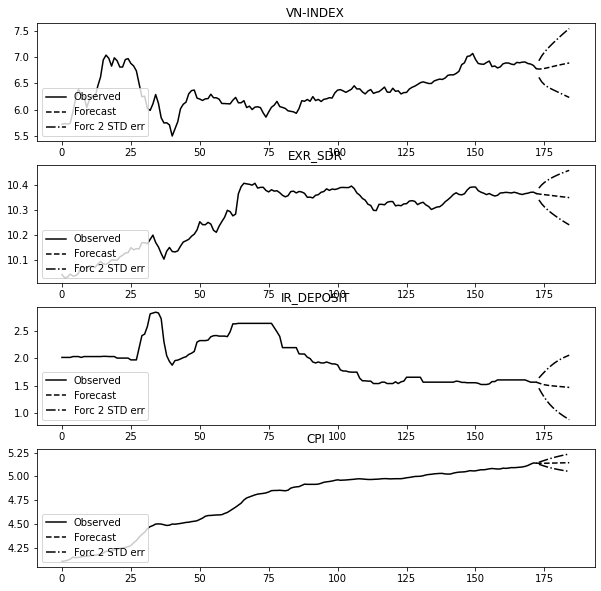

In [16]:
hose_vecm_fit.plot_forecast(steps = 12)

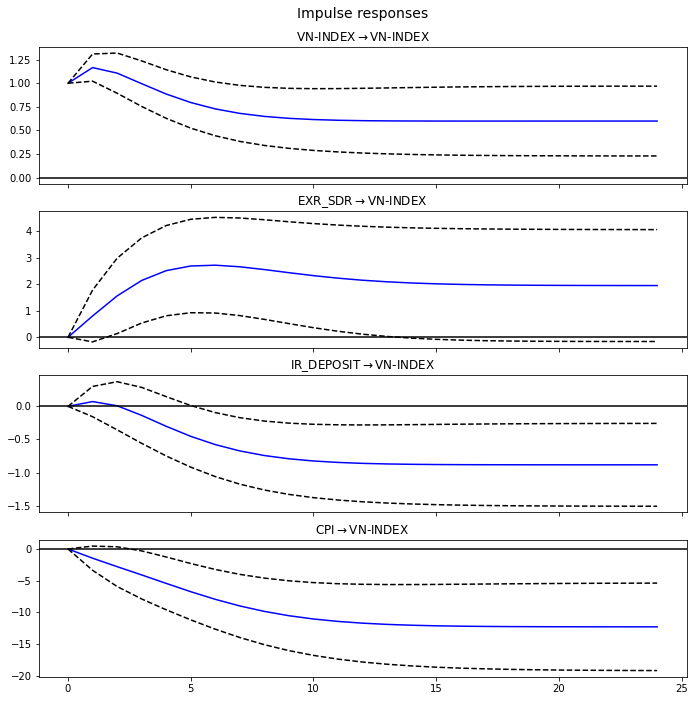

In [18]:
_ = hose_vecm_fit.irf(24).plot(response = "VN-INDEX", orth=False)

In [19]:
hose_vecm_fit.test_normality().summary()

Test statistic,Critical value,p-value,df
1082.,15.51,0.000,8


In [20]:
hose_vecm_fit.test_whiteness(nlags=5, adjusted=True).summary()

Test statistic,Critical value,p-value,df
84.14,79.08,0.022,60


### HNX

In [21]:
vec_rank1 = select_coint_rank(hnx_macro.loc["2005-07-31":"2020-06-30"], 
                              det_order = 1,
                              k_ar_diff = 1, 
                              method = 'maxeig',
                              signif=0.05)
print(vec_rank1.summary())
select_order(hnx_macro.loc["2005-07-31":"2020-06-30"], maxlags = 10, deterministic="colo").summary()

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          30.12          30.82
-------------------------------------


,AIC,BIC,FPE,HQIC
0,-29.34,-28.82,1.820e-13,-29.12
1,-30.10,-29.28*,8.510e-14,-29.76*
2,-30.07,-28.96,8.698e-14,-29.62
3,-30.14*,-28.73,8.196e-14*,-29.57
4,-30.06,-28.36,8.881e-14,-29.37
5,-30.01,-28.01,9.395e-14,-29.20
6,-30.10,-27.80,8.599e-14,-29.17
7,-29.99,-27.40,9.666e-14,-28.94
8,-29.96,-27.07,1.005e-13,-28.79
9,-29.96,-26.77,1.019e-13,-28.67


In [9]:
vecm = VECM(endog = hnx_macro.loc["2005-07-31":"2020-02-28"], 
            k_ar_diff = 2, 
            coint_rank = 1, 
            deterministic = "colo")
hnx_vecm_fit = vecm.fit()
hnx_vecm_fit.summary().tables[-1]

,coef,std err,z,P>|z|,[0.025,0.975]
beta.1,1.0000,0,0,0.000,1.000,1.000
beta.2,-5.9965,0.935,-6.413,0.000,-7.829,-4.164
beta.3,0.0291,0.151,0.193,0.847,-0.266,0.324
beta.4,0.7884,0.130,6.088,0.000,0.535,1.042
beta.5,7.8950,0.722,10.935,0.000,6.480,9.310


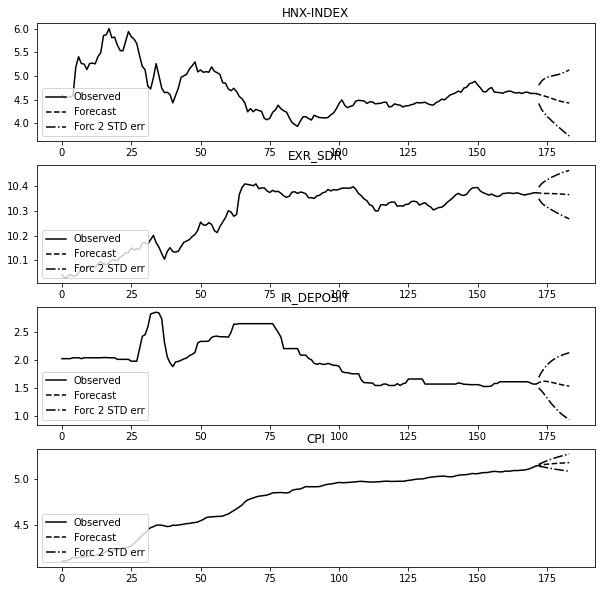

In [25]:
hnx_vecm_fit.plot_forecast(steps = 12)

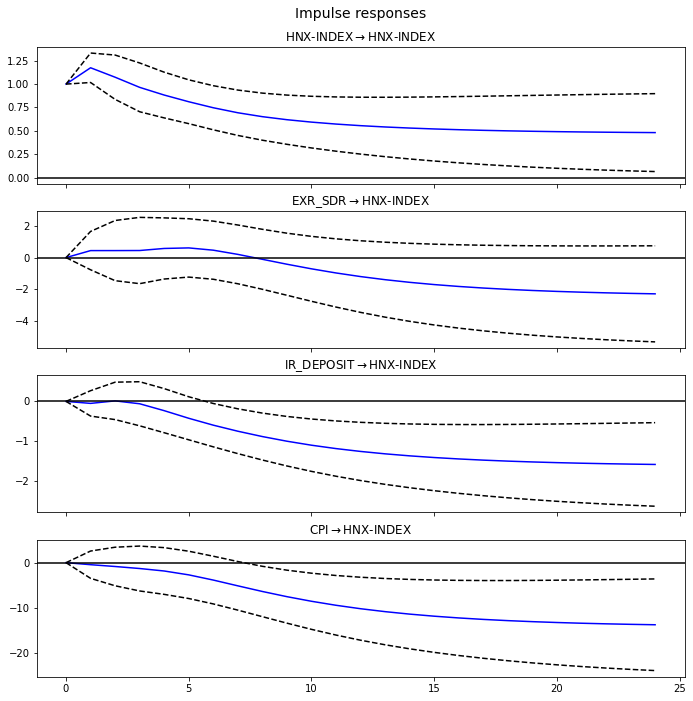

In [26]:
_ = hnx_vecm_fit.irf(24).plot(response = "HNX-INDEX", orth=False)

In [27]:
hnx_vecm_fit.test_granger_causality( caused = "HNX-INDEX", causing= ['EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
0.4775,1.895,0.890,"(9, 612)"


In [28]:
hnx_vecm_fit.test_inst_causality( causing= [ 'EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
19.01,7.815,0.000,3


In [29]:
hnx_vecm_fit.test_normality().summary()

Test statistic,Critical value,p-value,df
1064.,15.51,0.000,8


In [30]:
hnx_vecm_fit.test_whiteness(nlags=5, adjusted=True).summary()

Test statistic,Critical value,p-value,df
67.79,60.48,0.012,44


## Fitting SARIMAX Models

In [31]:
def plot_predictions(data, full_res, cutoff, dynamic_cutoff,title, ylable):
    # One-step ahead
    predict = full_res.get_prediction()
    predict_ci = predict.conf_int()
    # Dynamic predictions
    predict_dy = full_res.get_prediction(dynamic= dynamic_cutoff)
    predict_dy_ci = predict_dy.conf_int()
    # Graph
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 4
    ax.set(title=title, xlabel='Date', ylabel=ylable)

    # Plot data points
    data.loc[cutoff:, title].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    # One-step-ahead
    predict.predicted_mean.loc[cutoff:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = predict_ci.loc[cutoff:]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    # Dynamix
    predict_dy.predicted_mean.loc[cutoff:].plot(ax=ax, style='g', label=f'Dynamic forecast({dynamic_cutoff}) ')
    ci = predict_dy_ci.loc[cutoff:]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
    legend = ax.legend(loc='lower right')

### HOSE

In [33]:
endog = hose_macro.loc[:,"VN-INDEX"]
exog = hose_macro.loc[:,['EXR_SDR', 'IR_DEPOSIT', 'CPI'] ]

# Fit the model with data exluding the last 10 months of 2020
hose_mod = sm.tsa.statespace.SARIMAX(endog.loc[:"2020-02-28"], exog.loc[:"2020-02-28"], order=(1,1,1))
hose_fit_tr = hose_mod.fit(disp=False)
print(hose_fit_tr.summary())

                               SARIMAX Results                                
Dep. Variable:               VN-INDEX   No. Observations:                  235
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 234.127
Date:                Tue, 13 Apr 2021   AIC                           -456.253
Time:                        16:11:21   BIC                           -435.521
Sample:                    07-31-2000   HQIC                          -447.894
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXR_SDR       -0.0709      0.424     -0.167      0.867      -0.902       0.761
IR_DEPOSIT    -0.0772      0.101     -0.767      0.443      -0.275       0.120
CPI           -0.3871      0.696     -0.556      0.5

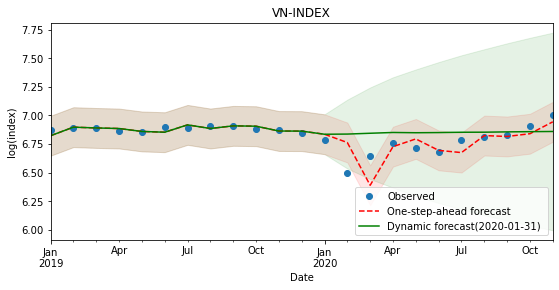

In [35]:
# Get predictions of left-out data using previously fit model
hose_full_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,1,1))
hose_fit_full = hose_full_mod.filter(hose_fit_tr.params)
plot_predictions(hose_macro, hose_fit_full, "2019-01-31", "2020-01-31", "VN-INDEX", "log(index)")

### HNX

In [36]:
endog = hnx_macro.loc[:,"HNX-INDEX"]
exog = hnx_macro.loc[:,['EXR_SDR', 'IR_DEPOSIT', 'CPI'] ]

# Fit the model with data exluding the last 10 months of 2020
hnx_mod = sm.tsa.statespace.SARIMAX(endog.loc[:"2020-06-30"], exog.loc[:"2020-06-30"], order=(1,1,1))
hnx_fit_tr = hnx_mod.fit(disp=False)
print(hnx_fit_tr.summary())

                               SARIMAX Results                                
Dep. Variable:              HNX-INDEX   No. Observations:                  180
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 157.264
Date:                Tue, 13 Apr 2021   AIC                           -302.529
Time:                        16:11:39   BIC                           -283.404
Sample:                    07-31-2005   HQIC                          -294.774
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXR_SDR        0.2047      0.603      0.340      0.734      -0.976       1.386
IR_DEPOSIT    -0.0196      0.151     -0.130      0.897      -0.315       0.276
CPI           -3.0194      0.863     -3.497      0.0

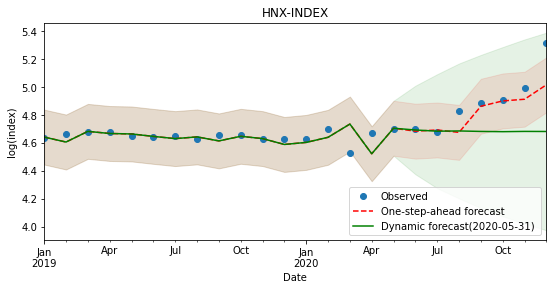

In [37]:
# Get predictions of left-out data using previously fit model
hnx_full_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,1,1))
hnx_fit_full = hnx_full_mod.filter(hnx_fit_tr.params)
plot_predictions(hnx_macro, hnx_fit_full, "2019-01-31", "2020-05-31", "HNX-INDEX", "log(index)")

### Evaluate models

In [38]:
hose_predict = hose_fit_full.get_prediction()
hose_tr_pred = hose_predict.predicted_mean.loc[:"2020-02-28"]
hose_te_pred = hose_predict.predicted_mean.loc["2020-02-28":]
print("VN-INDEX:")
print("In sample RMSE:", rmse(hose_macro.loc[:"2020-02-28","VN-INDEX"], hose_tr_pred))
print("In sample RMSPE:", rmspe(hose_macro.loc[:"2020-02-28","VN-INDEX"], hose_tr_pred))
print("Out sample RMSE:", rmse(hose_macro.loc["2020-02-28":,"VN-INDEX"], hose_te_pred))
print("Out sample RMSPE:", rmspe(hose_macro.loc["2020-02-28":,"VN-INDEX"], hose_te_pred))

VN-INDEX:
In sample RMSE: 0.459499671534216
In sample RMSPE: 0.9869748166391695
Out sample RMSE: 0.12857950143755542
Out sample RMSPE: 0.19457697330688017


In [39]:
hnx_predict = hnx_fit_full.get_prediction()
hnx_tr_pred = hnx_predict.predicted_mean.loc[:"2020-02-28"]
hnx_te_pred = hnx_predict.predicted_mean.loc["2020-02-28":]
print("HNX-INDEX:")
print("In sample RMSE:", rmse(hnx_macro.loc[:"2020-02-28","HNX-INDEX"], hnx_tr_pred))
print("In sample RMSPE:", rmspe(hnx_macro.loc[:"2020-02-28","HNX-INDEX"], hnx_tr_pred))
print("Out sample RMSE:", rmse(hnx_macro.loc["2020-02-28":,"HNX-INDEX"], hnx_te_pred))
print("Out sample RMSPE:", rmspe(hnx_macro.loc["2020-02-28":,"HNX-INDEX"], hnx_te_pred))

HNX-INDEX:
In sample RMSE: 1.1340249054311506
In sample RMSPE: 2.4653339912082752
Out sample RMSE: 0.1303826644731438
Out sample RMSPE: 0.2640136408240822
